# Coursework1: Convolutional Neural Networks 

## instructions

Please submit a version of this notebook containing your answers **together with your trained model** on CATe as CW2.zip. Write your answers in the cells below each question.

### Setting up working environment 

For this coursework you will need to train a large network, therefore we recommend you work with Google Colaboratory, which provides free GPU time. You will need a Google account to do so. 

Please log in to your account and go to the following page: https://colab.research.google.com. Then upload this notebook.

For GPU support, go to "Edit" -> "Notebook Settings", and select "Hardware accelerator" as "GPU".

You will need to install pytorch by running the following cell:

In [21]:
!pip install torch torchvision

## Introduction

For this coursework you will implement one of the most commonly used model for image recognition tasks, the Residual Network. The architecture is introduced in 2015 by Kaiming He, et al. in the paper ["Deep residual learning for image recognition"](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/He_Deep_Residual_Learning_CVPR_2016_paper.pdf). 
<br>

In a residual network, each block contains some convolutional layers, plus "skip" connections, which allow the activations to by pass a layer, and then be summed up with the activations of the skipped layer. The image below illustrates a building block in residual networks.

![resnet-block](utils/resnet-block.png)


Depending on the number of building blocks, resnets can have different architectures, for example ResNet-50, ResNet-101 and etc. Here you are required to build ResNet-18 to perform classification on the CIFAR-10 dataset, therefore your network will have the following architecture:

![resnet](utils/resnet.png)

## Part 1 (40 points)

In this part, you will use basic pytorch operations to define the 2D convolution, max pooling operation, linear layer as well as 2d batch normalization. 

### YOUR TASK

- implement the forward pass for Conv2D, MaxPool2D, Linear and BatchNorm2d
- You are **NOT** allowed to use the torch.nn modules

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Conv2d(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 stride=1,
                 padding=0,
                 bias=True):

        super(Conv2d, self).__init__()
        """
        An implementation of a convolutional layer.

        The input consists of N data points, each with C channels, height H and
        width W. We convolve each input with F different filters, where each filter
        spans all C channels and has height HH and width WW.

        Parameters:
        - w: Filter weights of shape (F, C, HH, WW)
        - b: Biases, of shape (F,)
        - kernel_size: Size of the convolving kernel
        - stride: The number of pixels between adjacent receptive fields in the
            horizontal and vertical directions.
        - padding: The number of pixels that will be used to zero-pad the input.
        """

        ########################################################################
        # TODO: Define the parameters used in the forward pass                 #
        ########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        # - Convolution Parameters - (Accommodate Tuples)
        # kernel size
        if type(kernel_size) is tuple:
          self.kh, self.kw = kernel_size
        elif type(kernel_size) is int:
          self.kh, self.kw = kernel_size, kernel_size

        # stride
        if type(stride) is tuple:
          self.sh, self.sw = stride
        elif type(stride) is int:
          self.sh, self.sw = stride, stride

        # padding
        if type(padding) is tuple:
          self.ph, self.pw = padding
        elif type(padding) is int:
          self.ph, self.pw = padding, padding

        # channel sizes
        self.in_channels = in_channels
        self.out_channels = out_channels

        # use bias 
        self.bias = bias
        
        # - Initialize Weights and Bias - 
        self.w = torch.rand(out_channels, in_channels, self.kh, self.kw)
        self.b = torch.zeros(out_channels)  # Initialized as zero as common practice

        # Note: The Parameter function is not used as it exceeds requirements.  
        # self.b = torch.nn.Parameter(torch.zeros(out_channels,))

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

    def forward(self, x):
        """
        Input:
        - x: Input data of shape (N, C, H, W)
        Output:
        - out: Output data, of shape (N, F, H', W').
        """

        ########################################################################
        # TODO: Implement the forward pass                                     #
        ########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        # Input shape
        batch_size, _, h, w = x.shape

        # Output dimensions
        w_out = ((w + 2*self.pw - self.kw)//self.sw) + 1
        h_out = ((h + 2*self.ph - self.kh)//self.sh) + 1

        # Unfold input
        x_unfolded = F.unfold(x, kernel_size=(self.kh, self.kw), 
                            stride=(self.sh,self.sw),
                            padding=(self.ph,self.pw))

        # - Perform matrix multiplication - 
        # with bias
        if self.bias:
          out_unfolded = (x_unfolded.transpose(1, 2).matmul(self.w.view(self.w.size(0), -1).t()) + self.b).transpose(1, 2)
        
        else:
          out_unfolded = x_unfolded.transpose(1, 2).matmul(self.w.view(self.w.size(0), -1).t()).transpose(1, 2)

        # - Reshaping into correct output format - 
        out = out_unfolded.view(batch_size, self.out_channels, h_out, w_out)

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

        return out

In [23]:
class MaxPool2d(nn.Module):
    def __init__(self, kernel_size):
        super(MaxPool2d, self).__init__()
        """
        An implementation of a max-pooling layer.

        Parameters:
        - kernel_size: the size of the window to take a max over
        """
        ########################################################################
        # TODO: Define the parameters used in the forward pass                 #
        ########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        # kernel size
        if type(kernel_size) is tuple:
          self.kh, self.kw = kernel_size
        elif type(kernel_size) is int:
          self.kh, self.kw = kernel_size, kernel_size

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

    def forward(self, x):
        """
        Input:
        - x: Input data of shape (N, C, H, W)
        Output:
        - out: Output data, of shape (N, F, H', W').
        """
        ########################################################################
        # TODO: Implement the forward pass                                     #
        ########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        # Create windows/patches
        windows = x.unfold(2, self.kh, self.kh).unfold(3, self.kw, self.kw)
        windows = windows.contiguous().view(*windows.size()[:-2], -1)

        # Take max value
        out, _ = windows.max(4)
        
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

        return out

In [24]:
class Linear(nn.Module):
    def __init__(self, in_channels, out_channels, bias=True):
        super(Linear, self).__init__()
        """
        An implementation of a Linear layer.

        Parameters:
        - weight: the learnable weights of the module of shape (in_channels, out_channels).
        - bias: the learnable bias of the module of shape (out_channels).
        """
        ########################################################################
        # TODO: Define the parameters used in the forward pass                 #
        ########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        # - Initialize Weights and Bias - 
        self.w = torch.rand(in_channels, out_channels)
        self.b = torch.zeros(out_channels)

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

    def forward(self, x):
        """
        Input:
        - x: Input data of shape (N, *, H) where * means any number of additional
        dimensions and H = in_channels
        Output:
        - out: Output data of shape (N, *, H') where * means any number of additional
        dimensions and H' = out_channels
        """
        ########################################################################
        # TODO: Implement the forward pass                                     #
        ########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        out = x @ self.w + self.b

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

        return out

In [25]:
class BatchNorm2d(nn.Module):
    def __init__(self, num_features, eps=1e-05, momentum=0.1):
        super(BatchNorm2d, self).__init__()
        """
        An implementation of a Batch Normalization over a mini-batch of 2D inputs.

        The mean and standard-deviation are calculated per-dimension over the
        mini-batches and gamma and beta are learnable parameter vectors of
        size num_features.

        Parameters:
        - num_features: C from an expected input of size (N, C, H, W).
        - eps: a value added to the denominator for numerical stability. Default: 1e-5
        - momentum: momentum – the value used for the running_mean and running_var
        computation. Default: 0.1
        - gamma: the learnable weights of shape (num_features).
        - beta: the learnable bias of the module of shape (num_features).
        """
        ########################################################################
        # TODO: Define the parameters used in the forward pass                 #
        ########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        # Parameters
        self.num_features = num_features
        self.eps = eps
        self.momentum = momentum
        self.gamma = torch.zeros(num_features)
        self.beta = torch.ones(num_features)

        # Testing variables
        self.running_mean = torch.zeros(1,num_features,1,1)
        self.running_var = torch.ones(1,num_features,1,1)

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

    def forward(self, x):
        """
        During training this layer keeps running estimates of its computed mean and
        variance, which are then used for normalization during evaluation.
        Input:
        - x: Input data of shape (N, C, H, W)
        Output:
        - out: Output data of shape (N, C, H, W) (same shape as input)
        """
        ########################################################################
        # TODO: Implement the forward pass                                     #
        #       (be aware of the difference for training and testing)          #
        ########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        
        # - Perform batch-normalization for training - 
        if self.training:
          mean = x.mean(dim=(0, 2, 3), keepdim=True)
          var = ((x - mean) ** 2).mean(dim=(0, 2, 3), keepdim=True)

          # calculate normalization
          x = (x - mean) / torch.sqrt(var + self.eps)
          
          # update moving averages
          self.running_mean = self.momentum * self.running_mean + (1.0 - self.momentum) * mean
          self.running_var = self.momentum * self.running_var + (1.0 - self.momentum) * var

        # - Perform batch-normalization for testing -
        else:
          x = (x - self.running_mean) / torch.sqrt(self.running_var + self.eps)

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

        return x

## Part 2

In this part, you will train a ResNet-18 defined on the CIFAR-10 dataset. Code for training and evaluation are provided. 

### Your Task

1. Train your network to achieve the best possible test set accuracy after a maximum of 10 epochs of training.

2. You can use techniques such as optimal hyper-parameter searching, data pre-processing

3. If necessary, you can also use another optimizer

4. **Answer the following question:**
Given such a network with a large number of trainable parameters, and a training set of a large number of data, what do you think is the best strategy for hyperparameter searching? 

 **Question answered in the *Discussion* section below**

In [26]:
import torch
from torch.nn import Conv2d, MaxPool2d
import torch.nn as nn
import torch.nn.functional as F

Next, we define ResNet-18:

In [27]:
# define resnet building blocks

class ResidualBlock(nn.Module): 
    def __init__(self, inchannel, outchannel, stride=1): 
        
        super(ResidualBlock, self).__init__() 
        
        self.left = nn.Sequential(Conv2d(inchannel, outchannel, kernel_size=3, 
                                         stride=stride, padding=1, bias=False), 
                                  nn.BatchNorm2d(outchannel), 
                                  nn.ReLU(inplace=True), 
                                  Conv2d(outchannel, outchannel, kernel_size=3, 
                                         stride=1, padding=1, bias=False), 
                                  nn.BatchNorm2d(outchannel)) 
        
        self.shortcut = nn.Sequential() 
        
        if stride != 1 or inchannel != outchannel: 
            
            self.shortcut = nn.Sequential(Conv2d(inchannel, outchannel, 
                                                 kernel_size=1, stride=stride, 
                                                 padding = 0, bias=False), 
                                          nn.BatchNorm2d(outchannel) ) 
            
    def forward(self, x): 
        
        out = self.left(x) 
        
        out += self.shortcut(x) 
        
        out = F.relu(out) 
        
        return out


    
    # define resnet

class ResNet(nn.Module):
    
    def __init__(self, ResidualBlock, num_classes = 10):
        
        super(ResNet, self).__init__()
        
        self.inchannel = 64
        self.conv1 = nn.Sequential(Conv2d(3, 64, kernel_size = 3, stride = 1,
                                            padding = 1, bias = False), 
                                  nn.BatchNorm2d(64), 
                                  nn.ReLU())
        
        self.layer1 = self.make_layer(ResidualBlock, 64, 2, stride = 1)
        self.layer2 = self.make_layer(ResidualBlock, 128, 2, stride = 2)
        self.layer3 = self.make_layer(ResidualBlock, 256, 2, stride = 2)
        self.layer4 = self.make_layer(ResidualBlock, 512, 2, stride = 2)
        self.maxpool = MaxPool2d(4)
        self.fc = nn.Linear(512, num_classes)
        
    
    def make_layer(self, block, channels, num_blocks, stride):
        
        strides = [stride] + [1] * (num_blocks - 1)
        
        layers = []
        
        for stride in strides:
            
            layers.append(block(self.inchannel, channels, stride))
            
            self.inchannel = channels
            
        return nn.Sequential(*layers)
    
    
    def forward(self, x):
        
        x = self.conv1(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.maxpool(x)
        
        x = x.view(x.size(0), -1)
        
        x = self.fc(x)
        
        return x
    
    
def ResNet18():
    return ResNet(ResidualBlock)

### Loading dataset
We will import images from the [torchvision.datasets](https://pytorch.org/docs/stable/torchvision/datasets.html) library <br>
First, we need to define the alterations (transforms) we want to perform to our images - given that transformations are applied when importing the data. <br>
Define the following transforms using the torchvision.datasets library -- you can read the transforms documentation [here](https://pytorch.org/docs/stable/torchvision/transforms.html): <br>
1. Convert images to tensor
2. Normalize mean and std of images with values:mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010]

In [28]:
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset

import numpy as np

import torchvision.transforms as T

##############################################################
#                       YOUR CODE HERE                       #       
##############################################################
basic_transform = T.Compose([T.ToTensor(), 
                       T.Normalize((0.4914, 0.4822, 0.4465), 
                                   (0.2023, 0.1994, 0.2010))])
##############################################################
#                       END OF YOUR CODE                     #
##############################################################




Now load the dataset using the transform you defined above, with batch_size = 64<br>
You can check the documentation [here](https://pytorch.org/docs/stable/torchvision/datasets.html).
Then create data loaders (using DataLoader from torch.utils.data) for the training and test set

In [29]:

##############################################################
#                       YOUR CODE HERE                       #       
##############################################################
data_dir = './data'
batch_size = 64

# Create dataset objects
cifar10_train = dset.CIFAR10(root = data_dir, train = True,
   download = True, transform = basic_transform)
cifar10_test = dset.CIFAR10(root = data_dir, train = False,
   download = True, transform = basic_transform)

# Create dataloaders
loader_train = DataLoader(dataset = cifar10_train, batch_size = batch_size, shuffle=False)
loader_test = DataLoader(dataset = cifar10_test, batch_size = batch_size, shuffle=False)
##############################################################
#                       END OF YOUR CODE                     #       
##############################################################



Files already downloaded and verified
Files already downloaded and verified


In [30]:
USE_GPU = True
dtype = torch.float32 

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
print_every = 100
def check_accuracy(loader, model):
    # function for test accuracy on validation and test set
    
    if loader.dataset.train:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')   
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))

def train_part(model, optimizer, epochs=1):
    """
    Train a model on CIFAR-10 using the PyTorch Module API.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    loss_log = []
    for e in range(epochs):
        print(len(loader_train))
        for t, (x, y) in enumerate(loader_train):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            loss.backward()

            # Update the parameters of the model using the gradients
            optimizer.step()

            if t % print_every == 0:
                print('Epoch: %d, Iteration %d, loss = %.4f' % (e, t, loss.item()))
                #check_accuracy(loader_val, model)
                print()

            # Log loss at each epoch
            loss_log.append(loss.item())
    
    return loss_log

# Discussion

### Data pre-processing
To increase the size of the input I performed data augmentation to artificially create more images. The specific transforms were chosen as ones that were realistic for the dataset at hand, such as flipping and rotating. Note as an important consideration the validation set was created without these transformations such as to best relfect generalization to the test set. 

One could also include the various transforms (and their parameters) in the hyper-parameter search to optimize the data augmentation as well. However, this was deemed to provide minimal benefit and at very great computational cost.

### Hyperparameters
Due to the open-ended nature of this part of the coursework the process of hyper-parameter tuning could have been approached in a number of different ways.  

Overall I determined the following hyper-parameters as theoretically influencing network performance. 

* Depth of ResNet (no. of residual blocks)
* Optimizer (Optimization algorithm)
* Activation Functions
* Loss Functions
* Batch size
* Learning rate
* Weight decay

Not all of these were explicitly tested and instead omitted from the search based on background reading and theoretical assumptions.

I decided to not increase network depth as the ResNet-18 was built for and performs very well on ImageNet, a considerably more complex dataset. Adding additional complexity to the model would only increase risk of overfitting (although with 10 epochs this is rather unlikely). Instead there might actually be a benefit to instead reduce the size of the ResNet to something like ResNet-12. This would improve training time and allow for better and more expansive hyper-parameter tuning. However, since again we are limited to 10 epochs in this CW the gain would not be too great. Similarly, the ReLU activation function has been consistently shown to work well in Residual Blocks thus changing that was also deemed redundant. Thus, overall the internal architecture of ResNet-18 is left unchanged. 

A manual search was used to quickly test different optimization algorithms, however, Adam consistently outperformed all of them. Variations such as AdamW were tested as well as a simple SGD with momentum, however, neither achieved superior performance. 

As this task is multi-class classification the loss function was kept as Cross-Entropy.

Therefore, the three parameters left for the final hyperparameter search were Batch size, Learning rate and Weight decay. Batch size and learning rate in particular are of interest due to the incorporation of batchnorm in the network. It has been shown that these variables can considerably change performance in such networks. 

### Search

To perform the hyperparameter search the following four approaches were considered.

* Manual Search
* Grid Search
* Random Search
* Bayesian Optimization


**4. Answer the following question:** Given such a network with a large number of trainable parameters, and a training set of a large number of data, what do you think is the best strategy for hyperparameter searching?

It is apparent that using an exhaustive but computationally heavy approach such as Grid Search is not feasible. Even in the small hyper-parameter space I defined for this CW the amount of permutations is already 5x6x3 = 120. Furthermore, a more exhaustive search would increase this number even further. 

A modification to the Grid Search such as making it greedy could reduce the number of training runs to 5+6+3 = 14, however, this relies on an unrealistic assumption that the hyperparameters are independent.

For such a problem the **best choice** is a Random Search. Since only really a small number of hyperparameters were deemed to affect the performance of the model it can be sufficiently parsed in this way. The optimization problem effectively has a low intrinsic dimensionality. Furthermore, the number of search iterations can be easily customized based on time or computational resources.

Of course the most rigorous approach would be to use Bayesian Optimization. Using a Bayesian approach for hyper-parameter tuning is very effective since the amount of data (i.e. evaluation runs) is low and uncertainty (i.e. noise) is high. However, for such a small problem it would likely result in only a small imporvement on the more simple methods such as random search. 


In [ ]:
# code for optimising your network performance

##############################################################
#                       YOUR CODE HERE                       #       
##############################################################
# Imports 
import random
from torch.utils.data.sampler import SubsetRandomSampler

# Reproducibility 
seed = 100
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
# random.seed(seed)

data_dir = './data'
batch_size = 64

# Data Augmentation 
augmentation_transform = T.Compose([T.ToTensor(), 
                         T.Normalize((0.4914, 0.4822, 0.4465), 
                                     (0.2023, 0.1994, 0.2010)),
                        #  T.RandomCrop(32, padding=2),
                         T.RandomHorizontalFlip(),
                         T.RandomRotation(20),
                        #  T.ColorJitter(hue=.05, saturation=.05),
                        # T.RandomAffine()
                         ])

# Create train dataset objects with augmentation transforms
cifar10_train_aug = dset.CIFAR10(root = data_dir, train = True,
   download = True, transform = augmentation_transform)
# Create train dataset objects with basic transforms
cifar10_train = dset.CIFAR10(root = data_dir, train = True,
   download = True, transform = basic_transform)

cifar10_test = dset.CIFAR10(root = data_dir, train = False,
   download = True, transform = basic_transform)

# Perform sampling using specific indices 
no_samples = len(cifar10_train_aug)
indices = list(range(no_samples))
np.random.shuffle(indices)
split = int(np.floor(0.2 * no_samples))
train_idx, val_idx = indices[split:], indices[:split]

# Define samplers to perform train/val split
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(val_idx)


############################
# Comment out below to avoid performing Random Search

# Hyper-Parameter space
batch_sizes = [16,32,64,128,256,512]
learning_rates = [0.1, 0.01, 0.001, 0.0001, 0.00001]
weight_decays = [0, 0.001, 0.0001]

# Creating a simple Random Search
i = 0
total_trials = 10
duplicates = []

while i < total_trials:
  params = [random.choice(batch_sizes), random.choice(learning_rates), 
                random.choice(weight_decays)]
  # Ensures no repetition 
  if params in duplicates:
    continue
  i += 1
  duplicates.append(params)

  # Print log
  print("Trial no:", i)
  print("Parameters:")
  print(" - Batch Size:", params[0])
  print(" - Learning Rate:", params[1])
  print(" - Weight Decay:", params[2])

  # Define dataloaders
  loader_train = DataLoader(cifar10_train_aug, sampler=train_sampler, 
                          batch_size = params[0], shuffle=False)
  # Note: validation set should not be augmented
  loader_val = DataLoader(cifar10_train, sampler=valid_sampler, 
                          batch_size = params[0], shuffle=False)

  # Define network
  model = ResNet18()
  optimizer = optim.Adam(model.parameters(), lr=params[1]
                         ,weight_decay = params[2], amsgrad = True)

  train_part(model, optimizer, epochs = 10)

  # report validation set accuracy
  check_accuracy(loader_val, model)

##############################################################
#                       END OF YOUR CODE                     #
##############################################################




In [35]:
# Using the optimal parameters from Hyper-Parameter search
batch_size = 64
learning_rate = 0.001
weight_decay = 0

# Train model with all training data (including validation set)
loader_train = DataLoader(cifar10_train_aug, batch_size = batch_size, shuffle=True)
loader_test = DataLoader(cifar10_test, batch_size = batch_size, shuffle=True)

# Define and train the network
model = ResNet18()
optimizer = optim.Adam(model.parameters(), lr = learning_rate, weight_decay = weight_decay, amsgrad = True)

loss_log = train_part(model, optimizer, epochs = 10)

# report test set accuracy
check_accuracy(loader_test, model)

# save the model
torch.save(model.state_dict(), 'model.pt')

782
Epoch: 0, Iteration 0, loss = 3.7895

Epoch: 0, Iteration 100, loss = 1.6227

Epoch: 0, Iteration 200, loss = 1.7154

Epoch: 0, Iteration 300, loss = 1.3791

Epoch: 0, Iteration 400, loss = 1.4394

Epoch: 0, Iteration 500, loss = 1.0332

Epoch: 0, Iteration 600, loss = 1.1281

Epoch: 0, Iteration 700, loss = 1.0535

782
Epoch: 1, Iteration 0, loss = 1.0446

Epoch: 1, Iteration 100, loss = 1.2579

Epoch: 1, Iteration 200, loss = 1.2359

Epoch: 1, Iteration 300, loss = 0.9735

Epoch: 1, Iteration 400, loss = 1.1024

Epoch: 1, Iteration 500, loss = 0.9221

Epoch: 1, Iteration 600, loss = 0.8488

Epoch: 1, Iteration 700, loss = 0.8772

782
Epoch: 2, Iteration 0, loss = 0.6303

Epoch: 2, Iteration 100, loss = 1.0436

Epoch: 2, Iteration 200, loss = 0.9849

Epoch: 2, Iteration 300, loss = 1.1439

Epoch: 2, Iteration 400, loss = 1.0138

Epoch: 2, Iteration 500, loss = 0.8529

Epoch: 2, Iteration 600, loss = 0.6641

Epoch: 2, Iteration 700, loss = 0.7319

782
Epoch: 3, Iteration 0, loss = 

## Part 3

The code provided below will allow you to visualise the feature maps computed by different layers of your network. Run the code (install matplotlib if necessary) and **answer the following questions**: 

**1. Compare the feature maps from low-level layers to high-level layers, what do you observe?**

The high level feature maps clearly capture the more general and more interpretable characteristics of the image. For example, after the first convolutional layer the activations highlight the outlines of the object. While it is not yet obvious what specific object is being represented the information embedded clearly give a clue.

Going down to the second layer (after the first residual block) the feature map is already more abstract. It appears as though this layer learns the more specific contours of the object.

From here on in the network the layers become even more abstract and quite meaningless to the human eye. Simply the resolution becomes so small in the later layers that no specific information can be inferred by inspection. However, the complex structure of the network means the model can utilize this pixel based information to make better predictions. 

Looking at the feature maps at each layer what can be noticed is the number of duplicate or very similar feature maps. While there are some feature maps that just have similar shapes different intensities, a lot of them appear to be exact copies. This suggests to me that the net is retaining redundant information due to its excessive complexity.

In the below code the feature maps for a single image are observed throughout the network. However, to better explore the different paths that can be taken through the network a Deep Dream approach could be used. This could allow for the exploration of the roles and representations of various parts of the network

**2. Use the training log, reported test set accuracy and the feature maps, analyse the performance of your network. If you think the performance is sufficiently good, explain why; if not, what might be the problem and how can you improve the performance?**

The clear limitation of the training is the number of epochs. For testing purposes I ran the training for 20 epochs and observed the loss curve. It appears that at 10 epochs the learning has yet to flatten out completely therefore more training epochs theoretically improve results. However, due to the simplicity of the problem it finished the majority of the learning in 10-20 epoch range. This is also reflected in the test accuracy of 89% achieved after 20 epochs. It should be noted that overfitting the data becomes a problem if the number of epochs is increased too much. The complexity of the model clearly exceeds the requirements of the dataset and task therefore it is realistic that given sufficient time it will begin to memorize the images as opposed to learning them. 

While the hyper-parameter search in the previous part was by no means exhaustive it is safe to assume that simple tuning would not significantly improve performance. Tuning the transforms used for the data augmentation might, however, improve the robustness of the input dataset. Furthermore, as with most deep learning tasks the performance could be improved through additional good data.

Note the hyper-parameter tuning and validation process could also be improved with something more robust such as cross-validation. This would give a better overview of the comparative results of each hyper-parameter. On the other hand, this would require even more computational resources. 

The achieved ~87% test accuracy is an acceptable result, however, it could definitely be improved upon. To compete with the top benchmark results of 90% and above would require customizing the architecture and finding the exact correct data manipulation. All of this obviously exceeds the scope of the coursework task. 


**3. What are the other possible ways to analyse the performance of your network?**

As with most classification tasks delving into the specific class based results could help determine how the network performs. In the cifar10 dataset not all classes are equally "difficult" so to get a better understanding of the exact prediction performance metrics such as precision, recall and F1 score could be used. A confusion matrix might also give some insights. 

Beyond the measures described in Q2 a possible approach would be to analyse interpretability. Explainable AI is a rapidly growing field since for many applications, such as health care, the classification rate itself is not a convincing enough measure. For example, in tumor detection just determining that it is a tumor might not be sufficient without some kind of explanation why. Thus, a highly performing model is both accurate and interpretable. 



**YOUR ANSWER FOR PART 3 HERE**

A:

<Figure size 432x288 with 0 Axes>

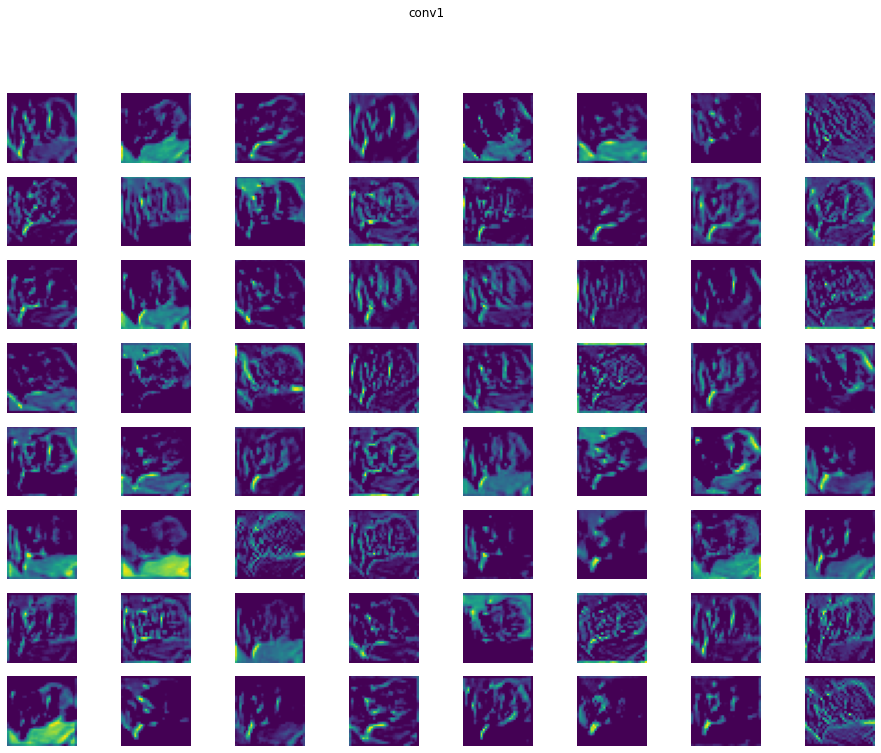

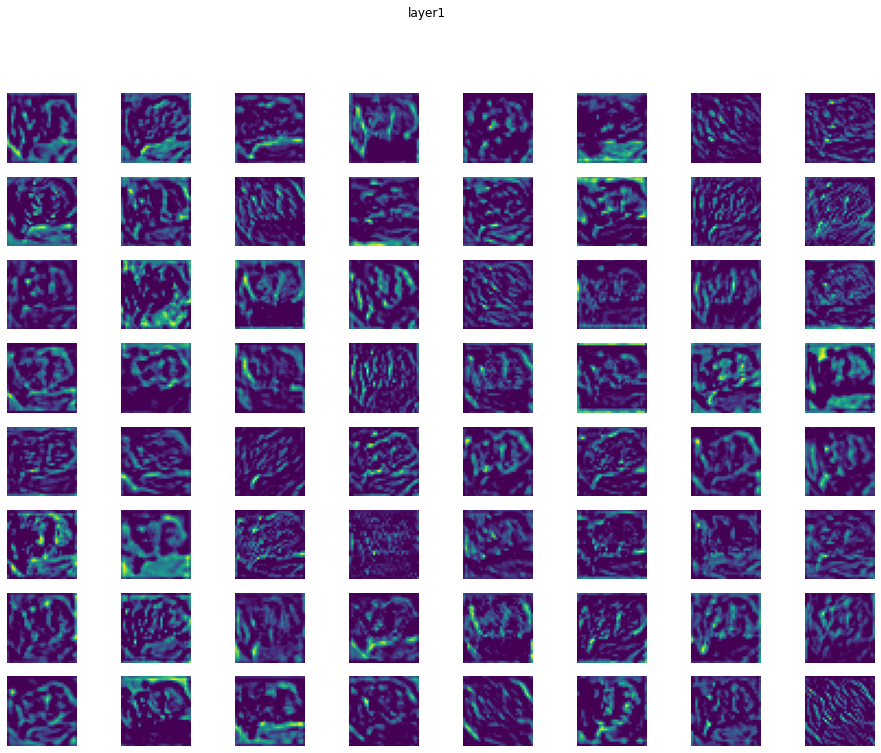

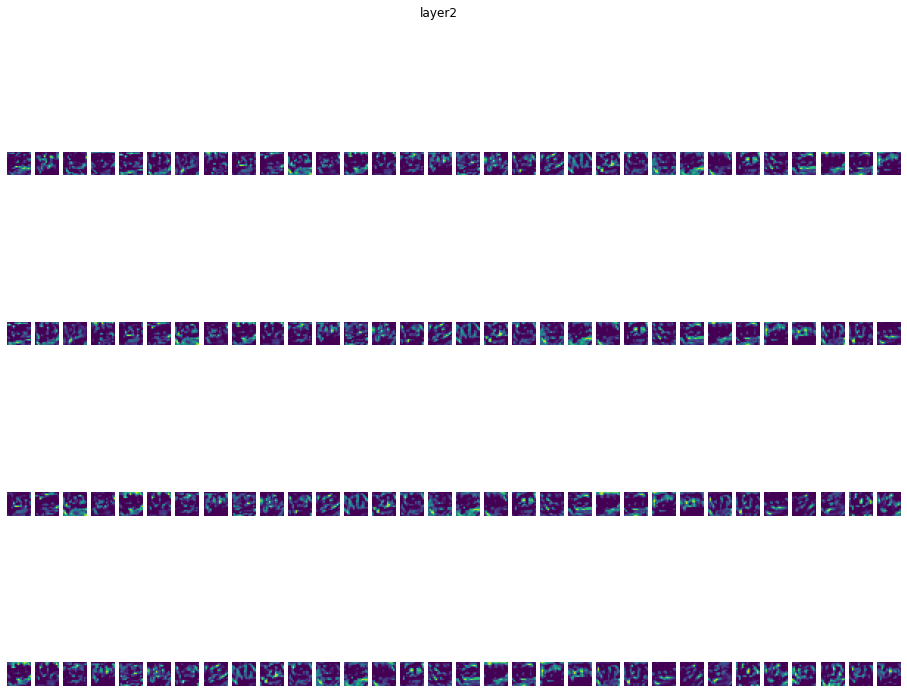

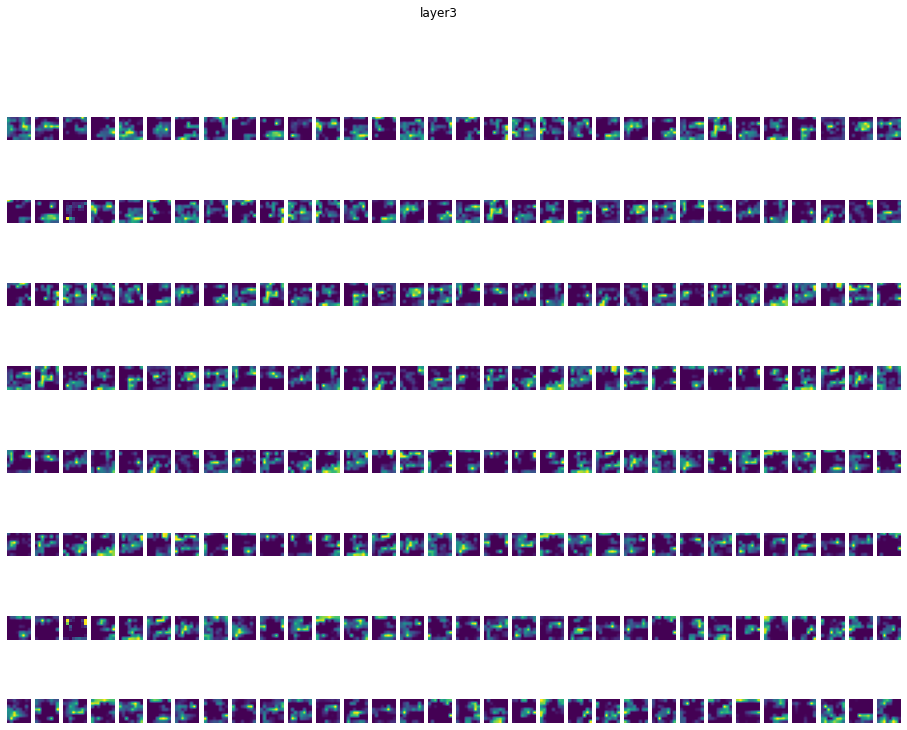

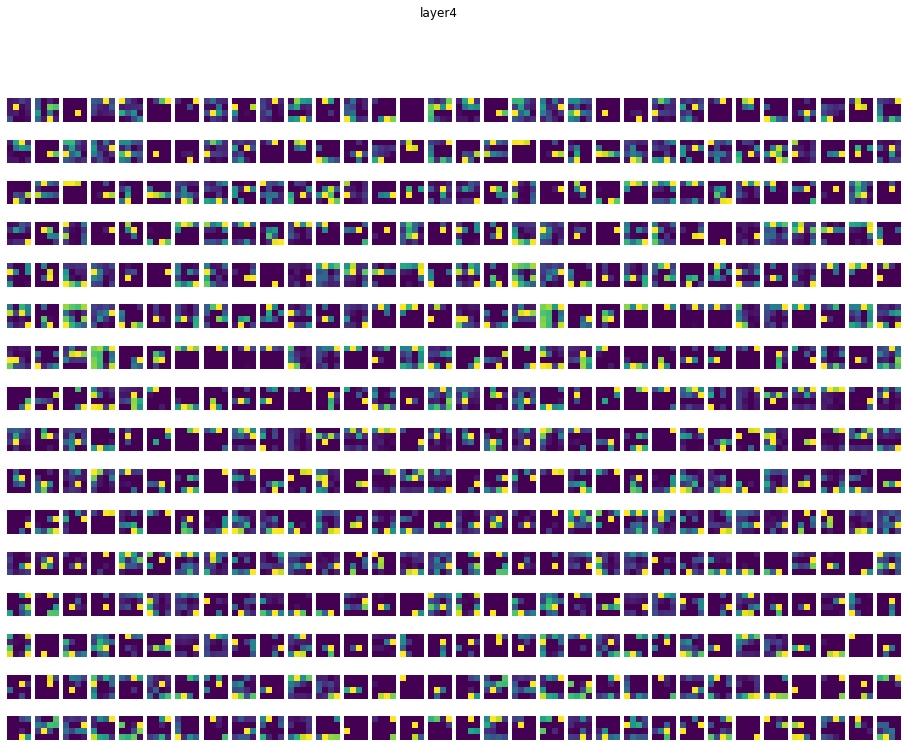

In [36]:
#!pip install matplotlib

import matplotlib.pyplot as plt

plt.tight_layout()


activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

vis_labels = ['conv1', 'layer1', 'layer2', 'layer3', 'layer4']

for l in vis_labels:

    getattr(model, l).register_forward_hook(get_activation(l))
    
    
data, _ = cifar10_test[0]

data = data.unsqueeze_(0).to(device = device, dtype = dtype)

output = model(data)



for idx, l in enumerate(vis_labels):

    act = activation[l].squeeze()

    if idx < 2:
        ncols = 8
    else:
        ncols = 32
        
    nrows = act.size(0) // ncols
    fig, axarr = plt.subplots(nrows, ncols, figsize=(16,12))
    fig.suptitle(l)


    for i in range(nrows):
        for j in range(ncols):
            axarr[i, j].imshow(act[i * nrows + j].cpu())
            axarr[i, j].axis('off')

In [ ]:
# Create Loss curve
x_axis = [i for i in range(len(loss_log))]
plt.plot(x_axis,loss_log)
plt.ylabel("Loss")
plt.show()
